Piyakorn Mona Munegan

Kaggle user name: Mona Munegan https://www.kaggle.com/piyakornmunegan

A code setub for accessing the dataset:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

from google.colab import drive
import time

import pickle
import json

drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'OTHER']
no_class = 8
dataset_directory = '/content/drive/My Drive/COMP8220/Project/data/'  ## CHANGE TO YOUR OWN DIRECTORY
saved_model_directory = '/content/drive/My Drive/COMP8220/Project/savedmodel/ood/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data Exploration

In [3]:
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))
m_images_train = np.load(join(dataset_directory, 'MNIST_dev_data_images.npy')) #MNIST
m_labels_train = np.load(join(dataset_directory, 'MNIST_dev_data_labels.npy')) #MNIST

#PublicTest set
images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_plus_data_images.npy'))  ## CHANGE TO APPROPRIATE PUBLIC TEST FILE

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])   
m_images_train = m_images_train.reshape([-1, image_size, image_size]) #MNIST

#Reshape MNIST lable
m_labels_train_T = m_labels_train.T #Transpose 
flat_m_labels = m_labels_train_T.flatten() #Flatten 2d numpy array into 1d array

#Concat face and MNIST image train
images_train_plus_m = np.concatenate((images_train, m_images_train), axis=0)

## Original dataset

In [12]:
print(labels_train)
print(m_labels_train)
print(m_labels_train_T)
print(flat_m_labels)

[0 6 3 ... 0 5 0]
[[3]
 [9]
 [5]
 ...
 [5]
 [2]
 [0]]
[[3 9 5 ... 5 2 0]]
[3 9 5 ... 5 2 0]


In [13]:
m_labels = flat_m_labels.copy()
for i in range(len(m_labels)):
    m_labels[i] = 7
m_labels

array([7, 7, 7, ..., 7, 7, 7])

In [14]:
valuesf, countsf = np.unique(labels_train, return_counts=True)
print("Face Uniqueue Lable: %s count %s" % (valuesf, countsf))
valuesm, countsm = np.unique(flat_m_labels, return_counts=True)
print("Original MNIST Uniqueue Lable: %s count %s" % (valuesm, countsm))

values, counts = np.unique(m_labels, return_counts=True)
print("Modified MNIST Uniqueue Lable: %s count %s" % (values, counts))

Face Uniqueue Lable: [0 1 2 3 4 5 6] count [1266  211 1107 2736 1043 1052 1913]
Original MNIST Uniqueue Lable: [0 1 2 3 4 5 6 7 8 9] count [141 154 146 141 162 141 155 172 133 155]
Modified MNIST Uniqueue Lable: [7] count [1500]


In [15]:
#Concat face and MNIST labels train
labels_train_plus_m = np.concatenate((labels_train, m_labels), axis=0)

In [ ]:
values, counts = np.unique(labels_train_plus_m, return_counts=True)
print("Face Plus MNIST Uniqueue Lable: %s count %s" % (values, counts))
print(labels_train_plus_m)

Face Plus MNIST Uniqueue Lable: [0 1 2 3 4 5 6 7] count [1266  211 1107 2736 1043 1052 1913 1500]
[0 6 3 ... 7 7 7]


In [ ]:
print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(m_images_train.shape)
print(m_labels.shape)
print(images_train_plus_m.shape)
print(labels_train_plus_m.shape)
print(f'Dataset has {images_train.shape[1]*images_train.shape[2]} features')

(9328, 48, 48)
(9328,)
(1636, 48, 48)
(1500, 48, 48)
(1500,)
(10828, 48, 48)
(10828,)
Dataset has 2304 features


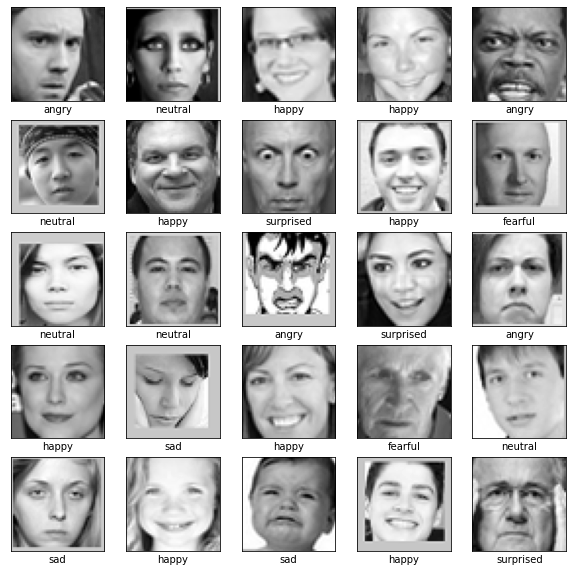

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS [ labels_train[i] ] )
plt.show()

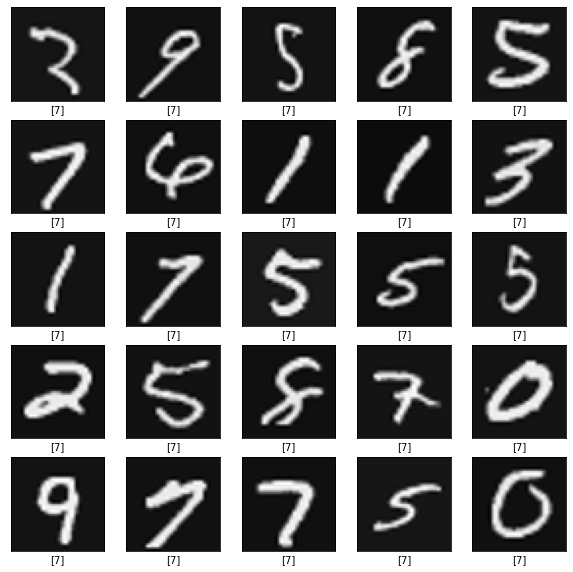

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(m_images_train[i], cmap='gray')
    plt.xlabel([m_labels[i]] )
plt.show()

In [ ]:
print(images_train_plus_m.shape)
print(labels_train_plus_m.shape)

(10828, 48, 48)
(10828,)


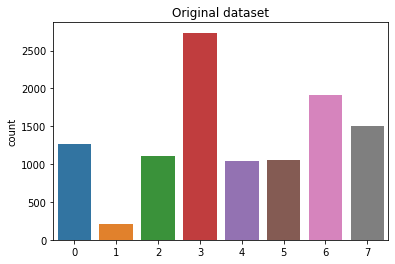

In [ ]:
fig, ax = plt.figsize=(20,5)
labels_train_plus_m.shape = len(labels_train_plus_m)
ax = sns.countplot(x=labels_train_plus_m).set_title('Original dataset')
#ax1.set_xticklabels(emotions.values())

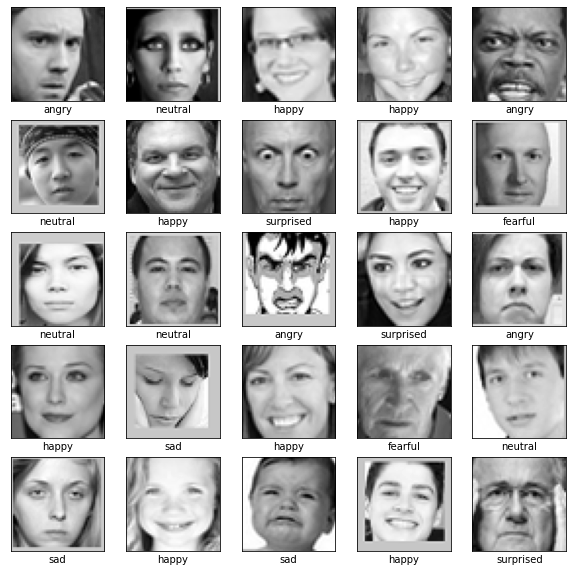

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train_plus_m[i], cmap='gray')
    plt.xlabel(EMOTIONS[labels_train_plus_m[i]])
plt.show()

### FER2013

In [4]:
filname = '/content/drive/My Drive/COMP8220/Project/data/fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/My Drive/COMP8220/Project/data/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [5]:
#https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook

def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [6]:
FER2013_images, FER2013_labels = getData(filname)
num_class = len(set(FER2013_labels))
print(num_class)

7


In [7]:
FER2013_images.shape

(35887, 2304)

In [8]:
FER2013_labels.shape

(35887,)

In [9]:
FER2013_images = FER2013_images.reshape([-1, image_size, image_size])
print(FER2013_images.shape)

(35887, 48, 48)


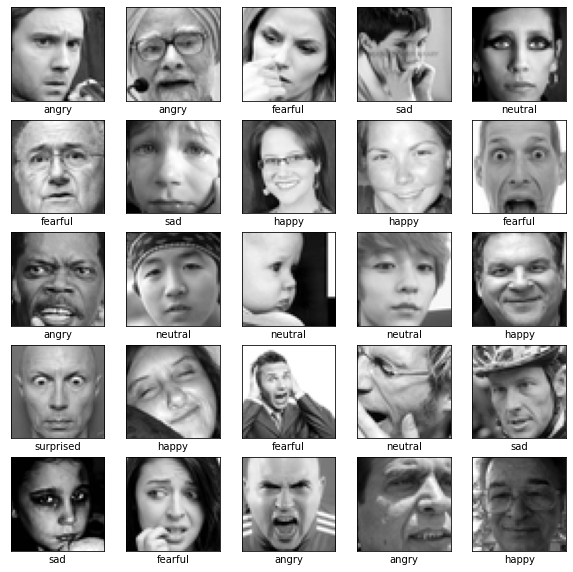

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(FER2013_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ FER2013_labels[i] ] )
plt.show()

In [11]:
#EMOTIONS dictionary
emotions = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral', 7: 'OTHER'}

# Data Preparation

## Original dataset

In [ ]:
print(images_train_plus_m.shape)
print(labels_train_plus_m.shape)

(10828, 48, 48)
(10828,)


In [ ]:
images_train_plus_m = images_train_plus_m/255.

In [ ]:
#(n_samples, height, width, channels)
images_train_plus_m = images_train_plus_m.reshape(-1, 48, 48, 1)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(images_train_plus_m, labels_train_plus_m, test_size = 0.1, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(7016, 48, 48, 1)
(7016,)
(1754, 48, 48, 1)
(1754,)
(1083, 48, 48, 1)
(1083,)


[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral'),
 Text(0, 0, 'OTHER')]

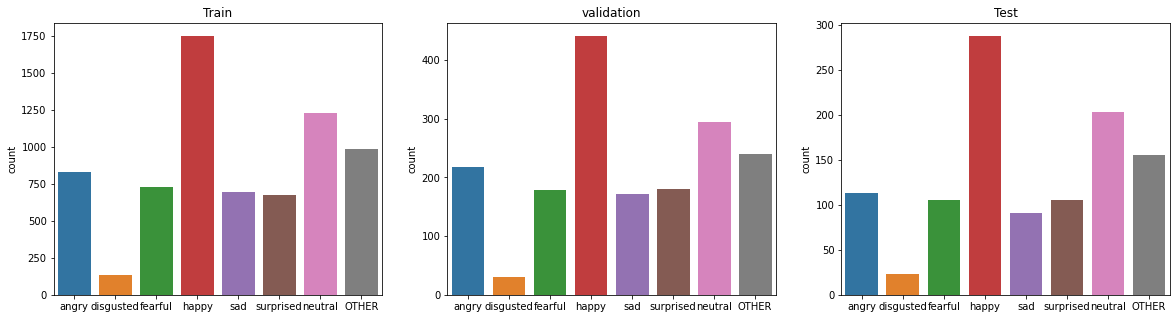

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values())
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values())
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values())

## FER2013

In [16]:
print(FER2013_images.shape)
print(FER2013_labels.shape)
print(m_images_train.shape)
print(m_labels.shape)

(35887, 48, 48)
(35887,)
(1500, 48, 48)
(1500,)


In [17]:
#Concat face and MNIST image train
FER2013_images_plus_m = np.concatenate((FER2013_images, m_images_train), axis=0)

In [18]:
#Concat face and MNIST labels train
FER2013_labels_plus_m = np.concatenate((FER2013_labels, m_labels), axis=0)

In [19]:
#(n_samples, height, width, channels)
FER2013_images_plus_m = FER2013_images_plus_m.reshape(-1, 48, 48, 1)

In [20]:
#35887+1500=37387
print(FER2013_images_plus_m.shape)
print(FER2013_labels_plus_m.shape)

(37387, 48, 48, 1)
(37387,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(FER2013_images_plus_m, FER2013_labels_plus_m, test_size = 0.1, random_state=42)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [23]:
#~70/20/10
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(26918, 48, 48, 1)
(26918,)
(6730, 48, 48, 1)
(6730,)
(3739, 48, 48, 1)
(3739,)


[Text(0, 0, 'angry'),
 Text(0, 0, 'disgusted'),
 Text(0, 0, 'fearful'),
 Text(0, 0, 'happy'),
 Text(0, 0, 'sad'),
 Text(0, 0, 'surprised'),
 Text(0, 0, 'neutral'),
 Text(0, 0, 'OTHER')]

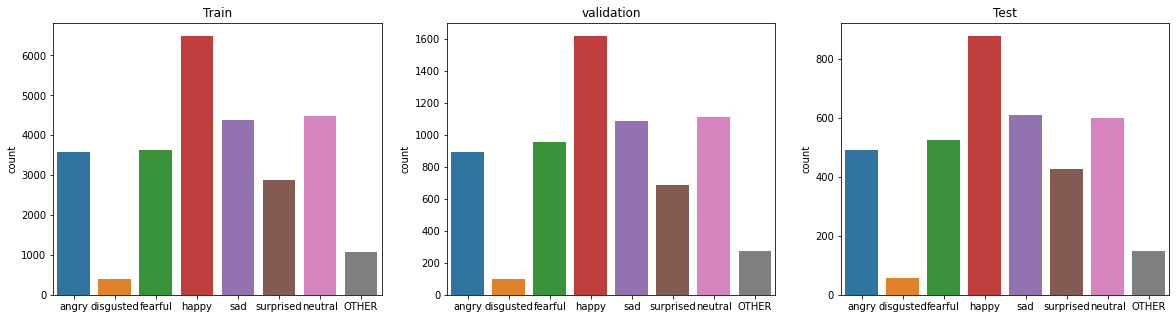

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
sns.countplot(x=y_train, ax=ax1).set_title('Train')
ax1.set_xticklabels(emotions.values())
sns.countplot(x=y_valid, ax=ax2).set_title('validation')
ax2.set_xticklabels(emotions.values())
sns.countplot(x=y_test, ax=ax3).set_title('Test')
ax3.set_xticklabels(emotions.values())

# Model bulding

##Simple CNN

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation= "relu", input_shape=[48, 48, 1]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.Dense(100, activation="sigmoid"),
    keras.layers.Dense(no_class, activation="softmax") #pick the highest prob.
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#n_epochs = 2
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
220/220 [==============================] - 4s 13ms/step - loss: 1.7205 - accuracy: 0.3414 - val_loss: 1.6359 - val_accuracy: 0.2970
Epoch 2/5
220/220 [==============================] - 3s 12ms/step - loss: 1.5285 - accuracy: 0.3932 - val_loss: 1.5124 - val_accuracy: 0.3900
Epoch 3/5
220/220 [==============================] - 3s 14ms/step - loss: 1.4817 - accuracy: 0.4250 - val_loss: 1.8984 - val_accuracy: 0.2007
Epoch 4/5
220/220 [==============================] - 3s 12ms/step - loss: 1.4155 - accuracy: 0.4672 - val_loss: 1.4040 - val_accuracy: 0.4675
Epoch 5/5
220/220 [==============================] - 3s 12ms/step - loss: 1.3570 - accuracy: 0.4930 - val_loss: 1.3267 - val_accuracy: 0.5177


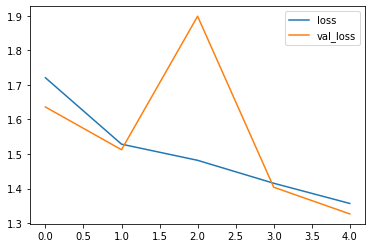

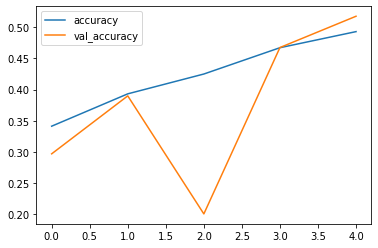

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 3ms/step - loss: 1.3066 - accuracy: 0.5300


[1.306593656539917, 0.5300092101097107]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.08, 0.02, 0.15, 0.24, 0.07, 0.17, 0.27, 0.  ],
       [0.13, 0.02, 0.1 , 0.37, 0.08, 0.06, 0.24, 0.  ],
       [0.28, 0.02, 0.1 , 0.07, 0.17, 0.03, 0.33, 0.  ]], dtype=float32)

In [ ]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [ ]:
np.argmax(y_pred[0])

0

In [ ]:
np.array(EMOTIONS)[y_pred[0]]

array(['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry',
       'angry'], dtype='<U9')

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

In [ ]:
#np.array(EMOTIONS)[y_pred]

In [ ]:
result = []
for i in range(len(y_pred)):
  r = np.argmax(y_pred[i])
  result.append(r)
arr = np.array(result)
#arr

In [ ]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

## CNN 1

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])

#default accuracy: 0.5880
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20)) #accuracy: 0.5290
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) #accuracy: 0.5790

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])
model.evaluate(X_test, y_test)

Epoch 1/10
220/220 [==============================] - 3s 10ms/step - loss: 1.9178 - accuracy: 0.2694 - val_loss: 1.7843 - val_accuracy: 0.3090
Epoch 2/10
220/220 [==============================] - 2s 9ms/step - loss: 1.6030 - accuracy: 0.3767 - val_loss: 1.5267 - val_accuracy: 0.3940
Epoch 3/10
220/220 [==============================] - 2s 9ms/step - loss: 1.5330 - accuracy: 0.3922 - val_loss: 1.4903 - val_accuracy: 0.4065
Epoch 4/10
220/220 [==============================] - 2s 9ms/step - loss: 1.4864 - accuracy: 0.4237 - val_loss: 1.4351 - val_accuracy: 0.4515
Epoch 5/10
220/220 [==============================] - 2s 9ms/step - loss: 1.4509 - accuracy: 0.4416 - val_loss: 1.4023 - val_accuracy: 0.4954
Epoch 6/10
220/220 [==============================] - 2s 8ms/step - loss: 1.4270 - accuracy: 0.4597 - val_loss: 1.4386 - val_accuracy: 0.4812
Epoch 7/10
220/220 [==============================] - 2s 9ms/step - loss: 1.4113 - accuracy: 0.4644 - val_loss: 1.3363 - val_accuracy: 0.4960
Epoch

[1.2729755640029907, 0.5567867159843445]

In [ ]:
#model.summary()

34/34 [==============================] - 0s 3ms/step - loss: 1.2730 - accuracy: 0.5568


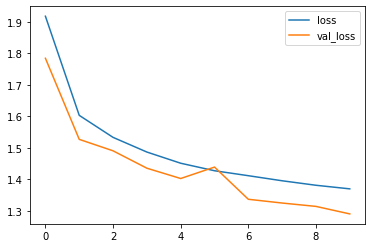

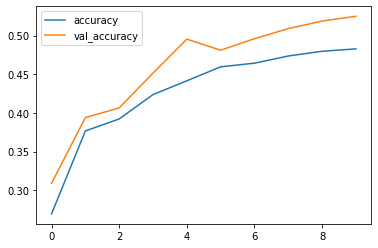

In [ ]:
#default
model.evaluate(X_test, y_test)
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

34/34 [==============================] - 0s 4ms/step - loss: 1.2730 - accuracy: 0.5568


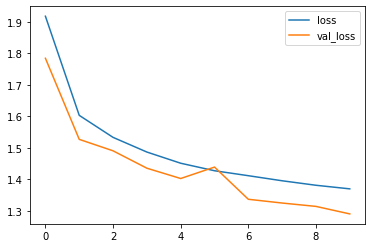

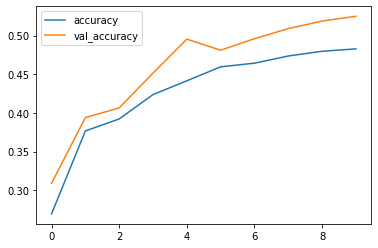

In [ ]:
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) #0.01
model.evaluate(X_test, y_test)
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

34/34 [==============================] - 0s 4ms/step - loss: 1.2730 - accuracy: 0.5568


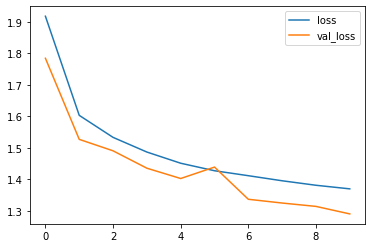

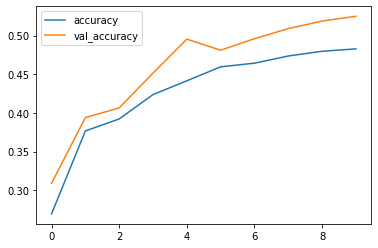

In [ ]:
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20)) #0.001
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN 2

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    
    
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])

#default accuracy: 0.5880
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20)) #accuracy: 0.5920
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20))  #accuracy: 0.5870
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"]) #accuracy: 0.6000

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

#model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])
model.evaluate(X_test, y_test)

Epoch 1/10
220/220 [==============================] - 4s 9ms/step - loss: 1.9744 - accuracy: 0.2444 - val_loss: 1.9492 - val_accuracy: 0.2514
Epoch 2/10
220/220 [==============================] - 2s 8ms/step - loss: 1.9566 - accuracy: 0.2469 - val_loss: 1.9132 - val_accuracy: 0.3586
Epoch 3/10
220/220 [==============================] - 2s 8ms/step - loss: 1.7982 - accuracy: 0.3217 - val_loss: 1.9141 - val_accuracy: 0.2514
Epoch 4/10
220/220 [==============================] - 2s 8ms/step - loss: 1.5827 - accuracy: 0.3821 - val_loss: 1.5497 - val_accuracy: 0.3877
Epoch 5/10
220/220 [==============================] - 2s 9ms/step - loss: 1.5548 - accuracy: 0.3881 - val_loss: 1.5276 - val_accuracy: 0.3877
Epoch 6/10
220/220 [==============================] - 2s 8ms/step - loss: 1.5381 - accuracy: 0.3911 - val_loss: 1.5197 - val_accuracy: 0.3883
Epoch 7/10
220/220 [==============================] - 2s 8ms/step - loss: 1.5272 - accuracy: 0.3932 - val_loss: 1.4969 - val_accuracy: 0.3957
Epoch 

[1.4365483522415161, 0.4653739631175995]

34/34 [==============================] - 0s 4ms/step - loss: 1.4365 - accuracy: 0.4654


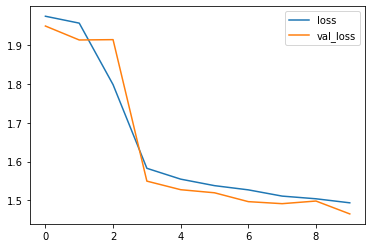

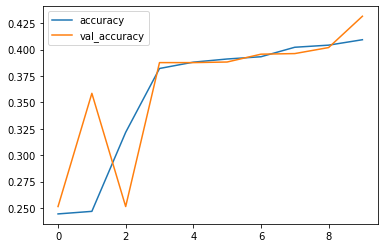

In [ ]:
#model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"]) #accuracy: 0.6000
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### LearningRateScheduler

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    
    
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(no_class, activation="softmax")
])


#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20))
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) 
#model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])
model.evaluate(X_test, y_test)

Epoch 1/10
220/220 [==============================] - 4s 9ms/step - loss: 1.9744 - accuracy: 0.2447 - val_loss: 1.9490 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/10
220/220 [==============================] - 2s 8ms/step - loss: 1.9599 - accuracy: 0.2439 - val_loss: 1.9733 - val_accuracy: 0.2514 - lr: 0.0011
Epoch 3/10
220/220 [==============================] - 2s 8ms/step - loss: 1.9549 - accuracy: 0.2520 - val_loss: 1.9577 - val_accuracy: 0.2514 - lr: 0.0013
Epoch 4/10
220/220 [==============================] - 2s 9ms/step - loss: 1.9514 - accuracy: 0.2491 - val_loss: 1.9566 - val_accuracy: 0.2514 - lr: 0.0014
Epoch 5/10
220/220 [==============================] - 2s 10ms/step - loss: 1.9533 - accuracy: 0.2491 - val_loss: 1.9429 - val_accuracy: 0.2514 - lr: 0.0016
Epoch 6/10
220/220 [==============================] - 2s 11ms/step - loss: 1.9487 - accuracy: 0.2491 - val_loss: 1.9462 - val_accuracy: 0.2514 - lr: 0.0018
Epoch 7/10
220/220 [==============================] - 2s 10ms/step -

[1.9262607097625732, 0.2659279704093933]

34/34 [==============================] - 0s 4ms/step - loss: 1.9263 - accuracy: 0.2659


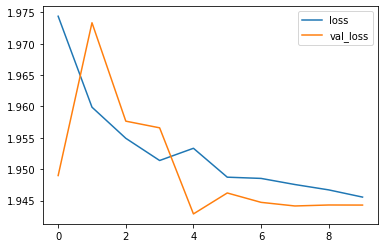

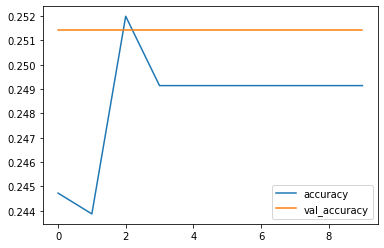

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN 3

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])


#### epoch = 20

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
220/220 [==============================] - 7s 17ms/step - loss: 1.7549 - accuracy: 0.3767 - val_loss: 3.8391 - val_accuracy: 0.2514
Epoch 2/20
220/220 [==============================] - 3s 15ms/step - loss: 1.4596 - accuracy: 0.4647 - val_loss: 3.8976 - val_accuracy: 0.1682
Epoch 3/20
220/220 [==============================] - 3s 16ms/step - loss: 1.3258 - accuracy: 0.5108 - val_loss: 2.6353 - val_accuracy: 0.1916
Epoch 4/20
220/220 [==============================] - 3s 15ms/step - loss: 1.2003 - accuracy: 0.5553 - val_loss: 1.2720 - val_accuracy: 0.5268
Epoch 5/20
220/220 [==============================] - 3s 15ms/step - loss: 1.1433 - accuracy: 0.5814 - val_loss: 1.1086 - val_accuracy: 0.5964
Epoch 6/20
220/220 [==============================] - 3s 15ms/step - loss: 1.0767 - accuracy: 0.6009 - val_loss: 2.1753 - val_accuracy: 0.2862
Epoch 7/20
220/220 [==============================] - 3s 15ms/step - loss: 1.0598 - accuracy: 0.6100 - val_loss: 1.0876 - val_accuracy: 0.5889

34/34 [==============================] - 0s 7ms/step - loss: 8.8035 - accuracy: 0.4949


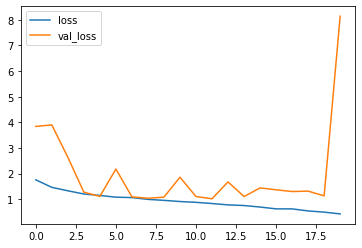

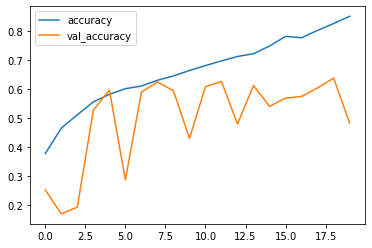

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### epoch = 50

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
220/220 [==============================] - 7s 17ms/step - loss: 1.7739 - accuracy: 0.3632 - val_loss: 2.6669 - val_accuracy: 0.2514
Epoch 2/50
220/220 [==============================] - 4s 17ms/step - loss: 1.4914 - accuracy: 0.4444 - val_loss: 2.8200 - val_accuracy: 0.2514
Epoch 3/50
220/220 [==============================] - 4s 18ms/step - loss: 1.3451 - accuracy: 0.5097 - val_loss: 1.7684 - val_accuracy: 0.3301
Epoch 4/50
220/220 [==============================] - 4s 17ms/step - loss: 1.2772 - accuracy: 0.5305 - val_loss: 2.3250 - val_accuracy: 0.3244
Epoch 5/50
220/220 [==============================] - 3s 15ms/step - loss: 1.1847 - accuracy: 0.5650 - val_loss: 1.3999 - val_accuracy: 0.5171
Epoch 6/50
220/220 [==============================] - 3s 15ms/step - loss: 1.1196 - accuracy: 0.5902 - val_loss: 2.9865 - val_accuracy: 0.3238
Epoch 7/50
220/220 [==============================] - 3s 15ms/step - loss: 1.0664 - accuracy: 0.6078 - val_loss: 1.2171 - val_accuracy: 0.5599

34/34 [==============================] - 0s 5ms/step - loss: 2.3227 - accuracy: 0.6464


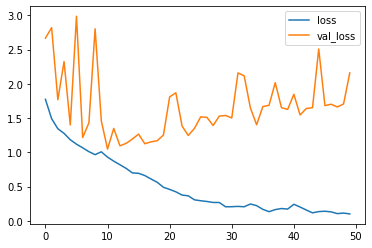

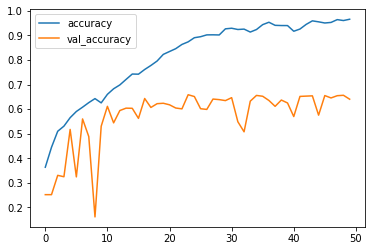

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### LearningRateScheduler1

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])

Epoch 1/20
220/220 [==============================] - 7s 16ms/step - loss: 1.7121 - accuracy: 0.3615 - val_loss: 11.4907 - val_accuracy: 0.2514 - lr: 0.0100
Epoch 2/20
220/220 [==============================] - 3s 15ms/step - loss: 1.5078 - accuracy: 0.4212 - val_loss: 2.7013 - val_accuracy: 0.2697 - lr: 0.0089
Epoch 3/20
220/220 [==============================] - 3s 15ms/step - loss: 1.3748 - accuracy: 0.4933 - val_loss: 2.5133 - val_accuracy: 0.3073 - lr: 0.0079
Epoch 4/20
220/220 [==============================] - 3s 15ms/step - loss: 1.2504 - accuracy: 0.5353 - val_loss: 2.5641 - val_accuracy: 0.2577 - lr: 0.0071
Epoch 5/20
220/220 [==============================] - 3s 15ms/step - loss: 1.1836 - accuracy: 0.5646 - val_loss: 1.5839 - val_accuracy: 0.3831 - lr: 0.0063
Epoch 6/20
220/220 [==============================] - 3s 15ms/step - loss: 1.1219 - accuracy: 0.5871 - val_loss: 16.3534 - val_accuracy: 0.1625 - lr: 0.0056
Epoch 7/20
220/220 [==============================] - 3s 15ms/

34/34 [==============================] - 0s 5ms/step - loss: 1.2791 - accuracy: 0.6676


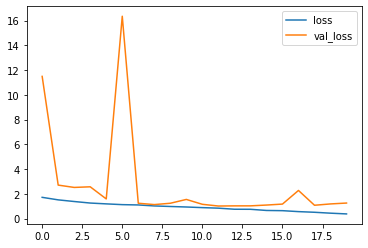

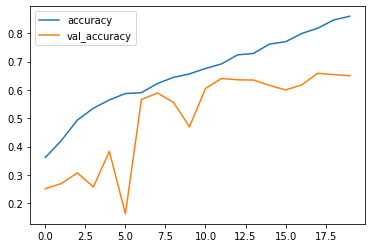

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### LearningRateScheduler2

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) 

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])

Epoch 1/20
220/220 [==============================] - 7s 16ms/step - loss: 1.7594 - accuracy: 0.3803 - val_loss: 4.4206 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/20
220/220 [==============================] - 3s 15ms/step - loss: 1.4660 - accuracy: 0.4647 - val_loss: 3.4662 - val_accuracy: 0.1682 - lr: 0.0011
Epoch 3/20
220/220 [==============================] - 3s 15ms/step - loss: 1.3654 - accuracy: 0.4967 - val_loss: 2.4855 - val_accuracy: 0.2788 - lr: 0.0013
Epoch 4/20
220/220 [==============================] - 3s 15ms/step - loss: 1.2369 - accuracy: 0.5439 - val_loss: 1.2806 - val_accuracy: 0.5416 - lr: 0.0014
Epoch 5/20
220/220 [==============================] - 3s 15ms/step - loss: 1.1700 - accuracy: 0.5683 - val_loss: 1.3366 - val_accuracy: 0.4989 - lr: 0.0016
Epoch 6/20
220/220 [==============================] - 3s 15ms/step - loss: 1.1378 - accuracy: 0.5810 - val_loss: 1.9571 - val_accuracy: 0.4943 - lr: 0.0018
Epoch 7/20
220/220 [==============================] - 3s 15ms/st

34/34 [==============================] - 0s 5ms/step - loss: 1.0171 - accuracy: 0.6427


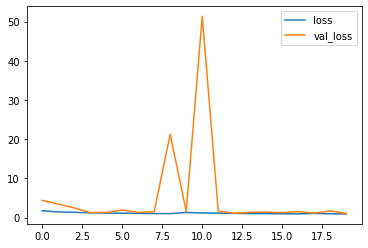

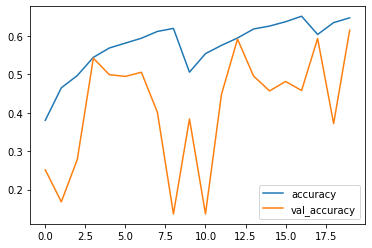

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 8s 22ms/step - loss: 1.8246 - accuracy: 0.3503 - val_loss: 2.8996 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 20ms/step - loss: 1.6067 - accuracy: 0.3874 - val_loss: 3.4424 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 20ms/step - loss: 1.5396 - accuracy: 0.4113 - val_loss: 3.4559 - val_accuracy: 0.1693 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 20ms/step - loss: 1.4676 - accuracy: 0.4386 - val_loss: 1.3488 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 20ms/step - loss: 1.4071 - accuracy: 0.4672 - val_loss: 1.3913 - val_accuracy: 0.4772 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 20ms/step - loss: 1.3570 - accuracy: 0.4986 - val_loss: 1.2294 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s 

[0.8413404226303101, 0.7100646495819092]

34/34 [==============================] - 0s 5ms/step - loss: 0.8413 - accuracy: 0.7101


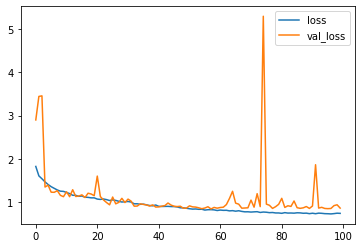

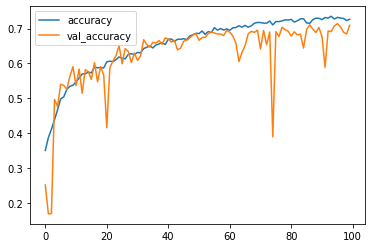

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation2

#### batch = 32

In [ ]:
#DataGenerator

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)

earlystopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(X_train, y_train, 32),
                                steps_per_epoch=len(X_train) / 32,
                                epochs=100,
                                callbacks = [earlystopping],
                                validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 9s 23ms/step - loss: 1.7963 - accuracy: 0.3511 - val_loss: 2.8286 - val_accuracy: 0.2514
Epoch 2/100
219/219 [==============================] - 5s 21ms/step - loss: 1.5746 - accuracy: 0.3955 - val_loss: 4.2981 - val_accuracy: 0.1682
Epoch 3/100
219/219 [==============================] - 5s 21ms/step - loss: 1.4992 - accuracy: 0.4339 - val_loss: 3.4280 - val_accuracy: 0.1887
Epoch 4/100
219/219 [==============================] - 5s 21ms/step - loss: 1.3687 - accuracy: 0.4876 - val_loss: 1.3636 - val_accuracy: 0.4989
Epoch 5/100
219/219 [==============================] - 5s 21ms/step - loss: 1.3224 - accuracy: 0.5094 - val_loss: 1.2097 - val_accuracy: 0.5433
Epoch 6/100
219/219 [==============================] - 5s 21ms/step - loss: 1.2857 - accuracy: 0.5291 - val_loss: 1.1819 - val_accuracy: 0.5587
Epoch 7/100
219/219 [==============================] - 5s 21ms/step - loss: 1.2657 - accuracy: 0.5386 - val_loss: 1.2625 - val_accuracy:

[1.01268470287323, 0.6325023174285889]

34/34 [==============================] - 0s 5ms/step - loss: 1.0127 - accuracy: 0.6325


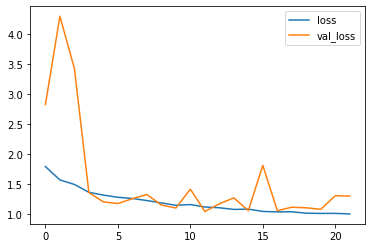

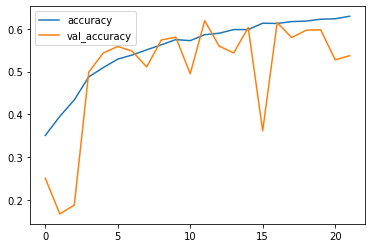

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#### batch = 64

In [ ]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=0.1,
                        horizontal_flip=True)
data_generator.fit(X_train)

earlystopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(data_generator.flow(X_train, y_train, 64),
                                steps_per_epoch=len(X_train) / 64,
                                epochs=50,
                                callbacks = [earlystopping],
                                validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/50
109/109 [==============================] - 8s 39ms/step - loss: 1.7884 - accuracy: 0.3575 - val_loss: 2.8981 - val_accuracy: 0.0981
Epoch 2/50
109/109 [==============================] - 4s 36ms/step - loss: 1.5516 - accuracy: 0.4007 - val_loss: 2.9009 - val_accuracy: 0.1682
Epoch 3/50
109/109 [==============================] - 4s 35ms/step - loss: 1.4541 - accuracy: 0.4511 - val_loss: 3.2021 - val_accuracy: 0.1682
Epoch 4/50
109/109 [==============================] - 4s 35ms/step - loss: 1.3889 - accuracy: 0.4758 - val_loss: 3.0663 - val_accuracy: 0.1682
Epoch 5/50
109/109 [==============================] - 4s 36ms/step - loss: 1.3123 - accuracy: 0.5131 - val_loss: 3.4959 - val_accuracy: 0.1682
Epoch 6/50
109/109 [==============================] - 4s 36ms/step - loss: 1.2789 - accuracy: 0.5207 - val_loss: 2.4686 - val_accuracy: 0.2269
Epoch 7/50
109/109 [==============================] - 4s 36ms/step - loss: 1.2335 - accuracy: 0.5396 - val_loss: 2.1568 - val_accuracy: 0.4333

[0.8966373205184937, 0.6814404726028442]

34/34 [==============================] - 0s 5ms/step - loss: 0.8966 - accuracy: 0.6814


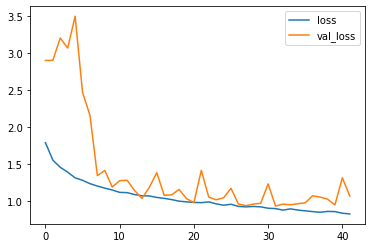

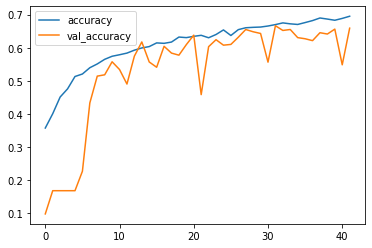

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN4

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=3, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),    

    keras.layers.Conv2D(128, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(512, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Dropout(0.25),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(256, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),


    keras.layers.Dense(no_class, activation="softmax")
])

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.01 * 0.1**(epoch/20))
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 10**(epoch/20)) 
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

#model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks = [lr_scheduler])
#model.evaluate(X_test, y_test)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 8s 22ms/step - loss: 1.8140 - accuracy: 0.3482 - val_loss: 3.4165 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 20ms/step - loss: 1.5762 - accuracy: 0.3934 - val_loss: 3.4915 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 21ms/step - loss: 1.4746 - accuracy: 0.4473 - val_loss: 2.5375 - val_accuracy: 0.2782 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 20ms/step - loss: 1.4306 - accuracy: 0.4651 - val_loss: 2.1524 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 20ms/step - loss: 1.3444 - accuracy: 0.4953 - val_loss: 1.8363 - val_accuracy: 0.3991 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 20ms/step - loss: 1.3093 - accuracy: 0.5084 - val_loss: 1.5543 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s 

[0.9986069798469543, 0.6472761034965515]

34/34 [==============================] - 0s 5ms/step - loss: 0.9986 - accuracy: 0.6473


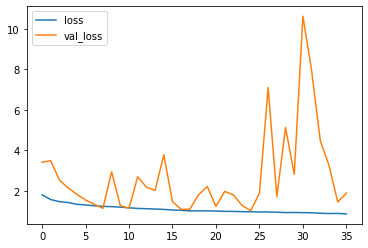

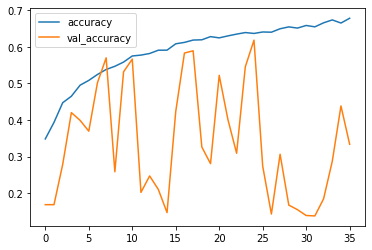

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN5

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

### Data Augmentation

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

In [ ]:
batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 12s 34ms/step - loss: 1.9050 - accuracy: 0.3365 - val_loss: 2.4728 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 6s 25ms/step - loss: 1.6088 - accuracy: 0.3837 - val_loss: 4.0208 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 22ms/step - loss: 1.5296 - accuracy: 0.4141 - val_loss: 2.0710 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 22ms/step - loss: 1.4606 - accuracy: 0.4400 - val_loss: 1.3030 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 22ms/step - loss: 1.4277 - accuracy: 0.4632 - val_loss: 3.3698 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 22ms/step - loss: 1.3819 - accuracy: 0.4879 - val_loss: 1.8707 - val_accuracy: 0.2828 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s

[0.762315034866333, 0.7248384356498718]

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

32/32 [==============================] - 0s 7ms/step - loss: 1.0532 - accuracy: 0.6330


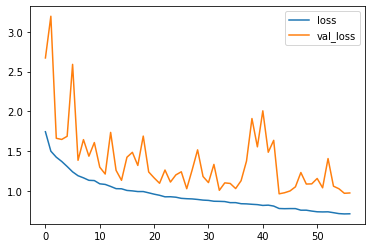

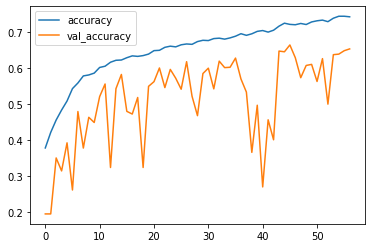

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation2

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 9s 24ms/step - loss: 1.8951 - accuracy: 0.3493 - val_loss: 2.6040 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 22ms/step - loss: 1.5564 - accuracy: 0.4215 - val_loss: 2.5934 - val_accuracy: 0.2052 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 22ms/step - loss: 1.4409 - accuracy: 0.4638 - val_loss: 1.4745 - val_accuracy: 0.4647 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 22ms/step - loss: 1.3679 - accuracy: 0.4930 - val_loss: 1.3119 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 22ms/step - loss: 1.3056 - accuracy: 0.5178 - val_loss: 1.3138 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 22ms/step - loss: 1.2450 - accuracy: 0.5436 - val_loss: 2.1590 - val_accuracy: 0.4880 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s 

[0.8299902677536011, 0.7137580513954163]

34/34 [==============================] - 0s 7ms/step - loss: 0.8300 - accuracy: 0.7138


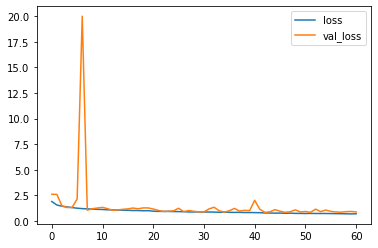

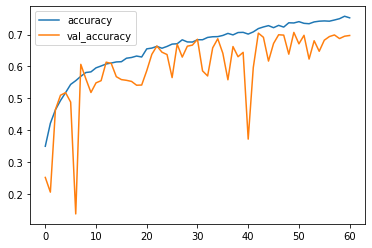

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

##### vertical_flip=True

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,
                        vertical_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 9s 23ms/step - loss: 1.9223 - accuracy: 0.3325 - val_loss: 2.7225 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 21ms/step - loss: 1.6126 - accuracy: 0.3841 - val_loss: 2.5975 - val_accuracy: 0.1682 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 21ms/step - loss: 1.5528 - accuracy: 0.4022 - val_loss: 2.3772 - val_accuracy: 0.1824 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 21ms/step - loss: 1.4810 - accuracy: 0.4294 - val_loss: 1.9519 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 21ms/step - loss: 1.4448 - accuracy: 0.4491 - val_loss: 1.8065 - val_accuracy: 0.3945 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 21ms/step - loss: 1.3911 - accuracy: 0.4815 - val_loss: 2.0759 - val_accuracy: 0.3415 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s 

[0.8173883557319641, 0.7109879851341248]

34/34 [==============================] - 0s 7ms/step - loss: 0.8174 - accuracy: 0.7110


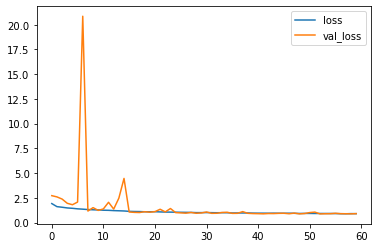

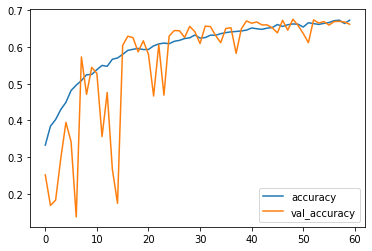

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation3

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:
data_generator3 = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator3.fit(X_train)

batch_size = 32 
history = model.fit(data_generator3.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 10s 24ms/step - loss: 1.8896 - accuracy: 0.3606 - val_loss: 2.4301 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 22ms/step - loss: 1.5557 - accuracy: 0.4182 - val_loss: 2.5873 - val_accuracy: 0.2520 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 22ms/step - loss: 1.4318 - accuracy: 0.4726 - val_loss: 1.7682 - val_accuracy: 0.3917 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 22ms/step - loss: 1.3659 - accuracy: 0.4966 - val_loss: 1.2429 - val_accuracy: 0.5393 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 22ms/step - loss: 1.3076 - accuracy: 0.5153 - val_loss: 1.3378 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 22ms/step - loss: 1.2500 - accuracy: 0.5495 - val_loss: 1.3932 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s

[0.7709307074546814, 0.7442290186882019]

34/34 [==============================] - 0s 7ms/step - loss: 0.7709 - accuracy: 0.7442


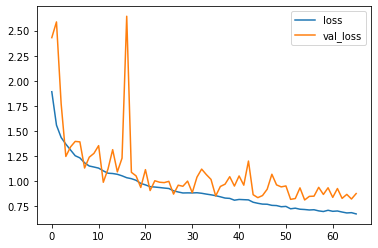

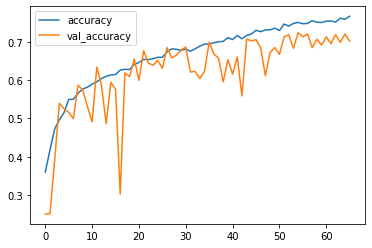

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation4

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
219/219 [==============================] - 9s 24ms/step - loss: 1.9408 - accuracy: 0.3263 - val_loss: 3.2935 - val_accuracy: 0.2514 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 22ms/step - loss: 1.6480 - accuracy: 0.3649 - val_loss: 2.5872 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 22ms/step - loss: 1.5768 - accuracy: 0.3788 - val_loss: 2.4425 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 5s 22ms/step - loss: 1.5320 - accuracy: 0.3978 - val_loss: 1.9568 - val_accuracy: 0.3176 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 6s 25ms/step - loss: 1.4979 - accuracy: 0.4183 - val_loss: 1.6799 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 22ms/step - loss: 1.4695 - accuracy: 0.4383 - val_loss: 1.5841 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 7/100
219/219 [==============================] - 5s 

[0.8091136813163757, 0.7109879851341248]

34/34 [==============================] - 0s 7ms/step - loss: 0.8091 - accuracy: 0.7110


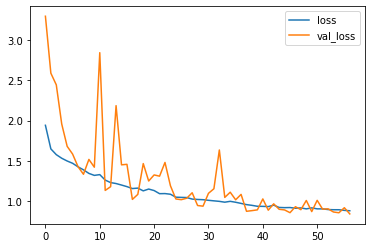

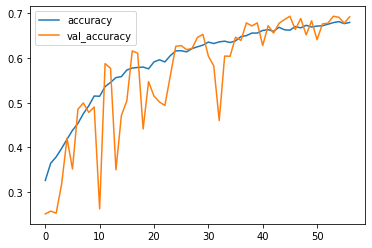

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

#Train model using larger dataset

## CNN5

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


### Data Augmentation

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

In [ ]:

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
data_generator.fit(X_train)

In [ ]:
batch_size = 32
history = model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 20ms/step - loss: 2.0403 - accuracy: 0.2511 - val_loss: 1.7151 - val_accuracy: 0.3459 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6393 - accuracy: 0.3561 - val_loss: 1.3869 - val_accuracy: 0.4686 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4721 - accuracy: 0.4297 - val_loss: 1.2970 - val_accuracy: 0.4982 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3907 - accuracy: 0.4671 - val_loss: 1.2406 - val_accuracy: 0.5284 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3221 - accuracy: 0.4994 - val_loss: 1.1785 - val_accuracy: 0.5541 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 17s 20ms/step - loss: 1.2868 - accuracy: 0.5104 - val_loss: 1.2046 - val_accuracy: 0.5504 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.8736042976379395, 0.6865472197532654]

117/117 [==============================] - 1s 6ms/step - loss: 0.8736 - accuracy: 0.6865


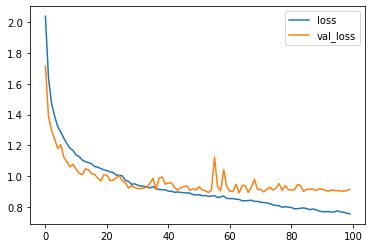

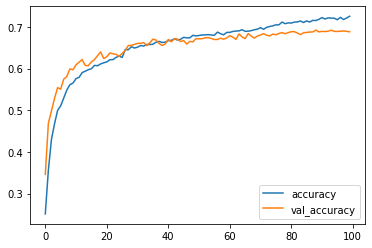

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation2

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 20ms/step - loss: 1.9604 - accuracy: 0.2966 - val_loss: 1.5434 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.5421 - accuracy: 0.4079 - val_loss: 1.3612 - val_accuracy: 0.4771 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 19s 22ms/step - loss: 1.4015 - accuracy: 0.4640 - val_loss: 1.2510 - val_accuracy: 0.5196 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 20s 23ms/step - loss: 1.3246 - accuracy: 0.4991 - val_loss: 1.2427 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 18s 21ms/step - loss: 1.2758 - accuracy: 0.5193 - val_loss: 1.2165 - val_accuracy: 0.5606 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 18s 22ms/step - loss: 1.2374 - accuracy: 0.5300 - val_loss: 1.1823 - val_accuracy: 0.5404 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.8890169858932495, 0.6913613080978394]

117/117 [==============================] - 1s 6ms/step - loss: 0.8890 - accuracy: 0.6914


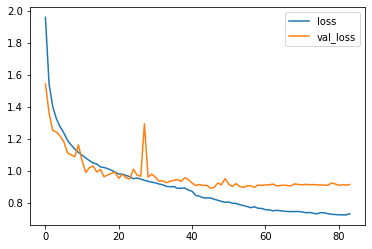

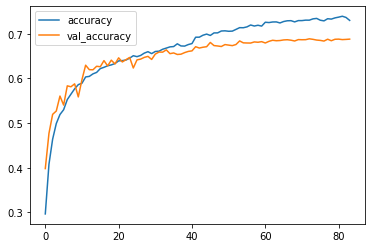

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

##### vertical_flip=True

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True,
                        vertical_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 20ms/step - loss: 2.0623 - accuracy: 0.2443 - val_loss: 1.6826 - val_accuracy: 0.3314 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.7050 - accuracy: 0.3238 - val_loss: 1.5760 - val_accuracy: 0.3773 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 18s 20ms/step - loss: 1.5756 - accuracy: 0.3845 - val_loss: 1.4840 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4818 - accuracy: 0.4284 - val_loss: 1.4450 - val_accuracy: 0.4660 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 18s 21ms/step - loss: 1.4043 - accuracy: 0.4591 - val_loss: 1.3447 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 18s 21ms/step - loss: 1.3479 - accuracy: 0.4864 - val_loss: 1.2747 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.9074448347091675, 0.6638138294219971]

117/117 [==============================] - 1s 6ms/step - loss: 0.9074 - accuracy: 0.6638


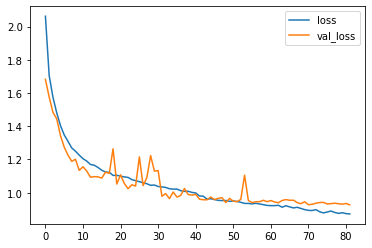

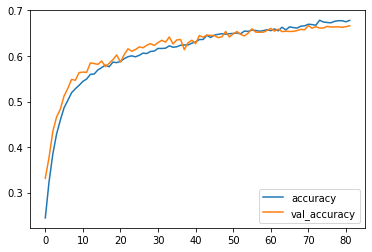

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation3

In [ ]:
data_generator3 = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
data_generator3.fit(X_train)

batch_size = 32 
history = model.fit(data_generator3.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 20ms/step - loss: 1.9665 - accuracy: 0.2880 - val_loss: 1.5091 - val_accuracy: 0.4169 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.5460 - accuracy: 0.4046 - val_loss: 1.4060 - val_accuracy: 0.4816 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3919 - accuracy: 0.4711 - val_loss: 1.2973 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3215 - accuracy: 0.4972 - val_loss: 1.1687 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.2676 - accuracy: 0.5215 - val_loss: 1.2029 - val_accuracy: 0.5498 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 17s 20ms/step - loss: 1.2250 - accuracy: 0.5407 - val_loss: 1.1360 - val_accuracy: 0.5689 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.8606232404708862, 0.6889542937278748]

117/117 [==============================] - 1s 6ms/step - loss: 0.8606 - accuracy: 0.6890


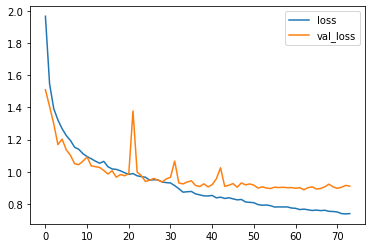

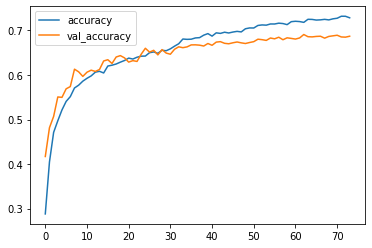

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation4

In [ ]:
data_generator2 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator2.fit(X_train)

batch_size = 32 
history = model.fit(data_generator2.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 20ms/step - loss: 2.1000 - accuracy: 0.2350 - val_loss: 1.7059 - val_accuracy: 0.3193 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.7243 - accuracy: 0.3043 - val_loss: 1.5939 - val_accuracy: 0.3777 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6177 - accuracy: 0.3619 - val_loss: 1.4107 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4968 - accuracy: 0.4168 - val_loss: 1.3888 - val_accuracy: 0.4728 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4088 - accuracy: 0.4620 - val_loss: 1.2513 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3573 - accuracy: 0.4841 - val_loss: 1.1837 - val_accuracy: 0.5478 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.8736947178840637, 0.6878844499588013]

117/117 [==============================] - 1s 6ms/step - loss: 0.8737 - accuracy: 0.6879


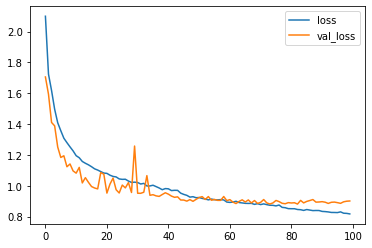

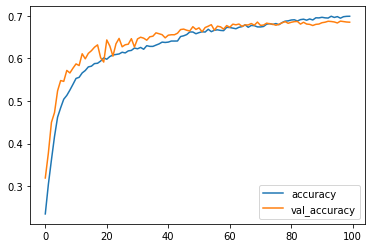

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

### Data Augmentation5


In [ ]:
data_generator5 = ImageDataGenerator(
                        rotation_range=5,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='nearest')
data_generator5.fit(X_train)

batch_size = 32 
history = model.fit(data_generator5.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

model.evaluate(X_test, y_test)

Epoch 1/100
841/841 [==============================] - 21s 21ms/step - loss: 2.0730 - accuracy: 0.2362 - val_loss: 1.7720 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.7664 - accuracy: 0.2862 - val_loss: 1.6513 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6857 - accuracy: 0.3219 - val_loss: 1.5768 - val_accuracy: 0.3752 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6194 - accuracy: 0.3596 - val_loss: 1.4647 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.5584 - accuracy: 0.3948 - val_loss: 1.4567 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 18s 20ms/step - loss: 1.4943 - accuracy: 0.4251 - val_loss: 1.3597 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[0.9086154699325562, 0.6608718633651733]

117/117 [==============================] - 1s 6ms/step - loss: 0.9086 - accuracy: 0.6609


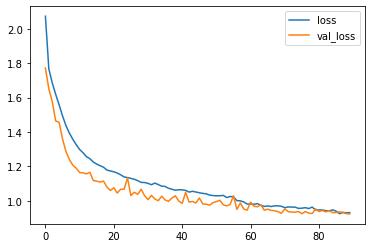

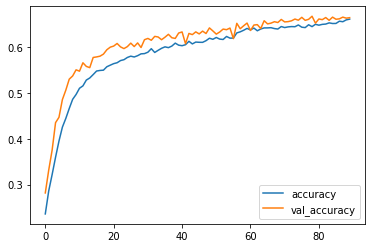

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN8

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 36s 26ms/step - loss: 1.9963 - accuracy: 0.2550 - val_loss: 1.6650 - val_accuracy: 0.3419 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 21s 25ms/step - loss: 1.6692 - accuracy: 0.3412 - val_loss: 1.3841 - val_accuracy: 0.4633 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 21s 25ms/step - loss: 1.5047 - accuracy: 0.4167 - val_loss: 1.3552 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 21s 25ms/step - loss: 1.3999 - accuracy: 0.4650 - val_loss: 1.2954 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 21s 25ms/step - loss: 1.3240 - accuracy: 0.4958 - val_loss: 1.1750 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 21s 25ms/step - loss: 1.2718 - accuracy: 0.5158 - val_loss: 1.1738 - val_accuracy: 0.5585 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 9ms/step - loss: 0.8763 - accuracy: 0.6972


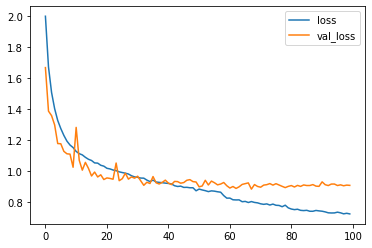

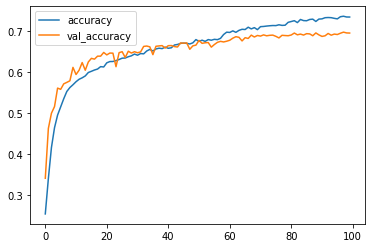

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

## CNN10

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 30s 19ms/step - loss: 2.0705 - accuracy: 0.2376 - val_loss: 1.6854 - val_accuracy: 0.3229 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 16s 19ms/step - loss: 1.7311 - accuracy: 0.3058 - val_loss: 1.5862 - val_accuracy: 0.3703 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6070 - accuracy: 0.3663 - val_loss: 1.5855 - val_accuracy: 0.4238 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 16s 19ms/step - loss: 1.4820 - accuracy: 0.4286 - val_loss: 1.3960 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4021 - accuracy: 0.4629 - val_loss: 1.2205 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 16s 19ms/step - loss: 1.3418 - accuracy: 0.4901 - val_loss: 1.2236 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 6ms/step - loss: 0.8402 - accuracy: 0.6951


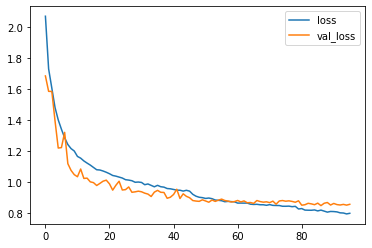

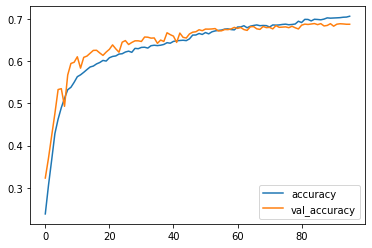

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN10_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN10_OOD_accuracy.jpg')

In [ ]:
# Save and load history obj. Dr. Fabien Tarrade https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [ ]:
model.save(saved_model_directory+'CNN10_OOD.h5')
with open(saved_model_directory +'/history_CNN10_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

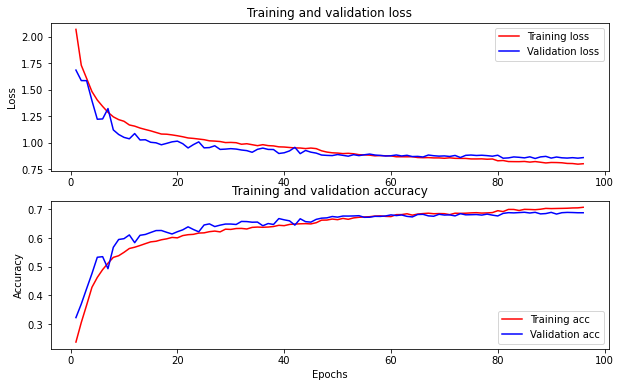

In [ ]:
with open(saved_model_directory +'/history_CNN10_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN10_OOD.jpg')

## CNN11

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 21s 21ms/step - loss: 2.1616 - accuracy: 0.2353 - val_loss: 1.6761 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.7564 - accuracy: 0.3040 - val_loss: 1.5809 - val_accuracy: 0.3835 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6186 - accuracy: 0.3685 - val_loss: 1.4017 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4947 - accuracy: 0.4269 - val_loss: 1.3093 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4133 - accuracy: 0.4567 - val_loss: 1.2861 - val_accuracy: 0.4969 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3559 - accuracy: 0.4870 - val_loss: 1.2245 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 6ms/step - loss: 0.8429 - accuracy: 0.7005


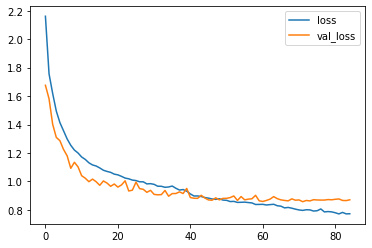

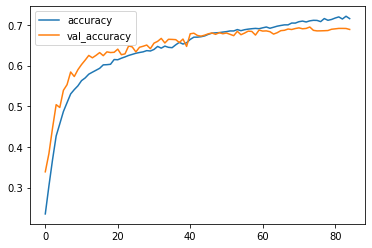

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN11_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN11_OOD_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN11_OOD.h5')

with open(saved_model_directory +'/history_CNN11_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

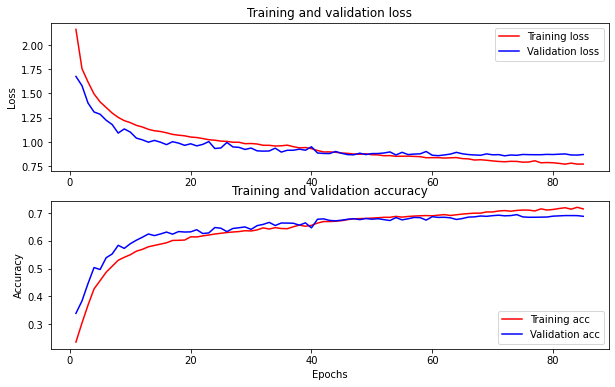

In [ ]:
with open(saved_model_directory +'/history_CNN11_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN11_OOD.jpg')

## CNN12

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),
    
    #Addition layer
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    #Addition layer
    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    #Addition layer
    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 22s 21ms/step - loss: 2.2368 - accuracy: 0.2185 - val_loss: 1.7203 - val_accuracy: 0.2897 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 17s 20ms/step - loss: 1.7848 - accuracy: 0.2675 - val_loss: 1.6660 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 17s 20ms/step - loss: 1.6777 - accuracy: 0.3258 - val_loss: 1.6635 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 17s 20ms/step - loss: 1.5566 - accuracy: 0.3910 - val_loss: 1.4635 - val_accuracy: 0.4374 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 17s 20ms/step - loss: 1.4518 - accuracy: 0.4428 - val_loss: 1.3052 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 17s 20ms/step - loss: 1.3842 - accuracy: 0.4728 - val_loss: 1.2459 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 6ms/step - loss: 0.8401 - accuracy: 0.6828


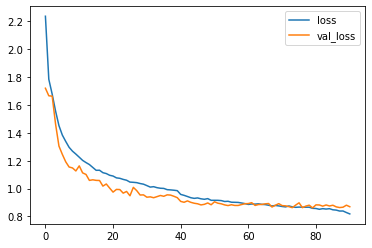

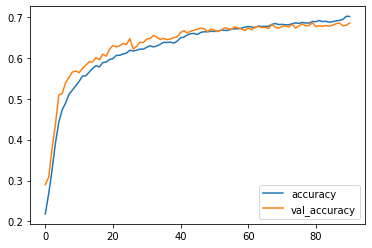

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN12_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN12_OOD_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN12_OOD.h5')

with open(saved_model_directory +'/history_CNN12_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

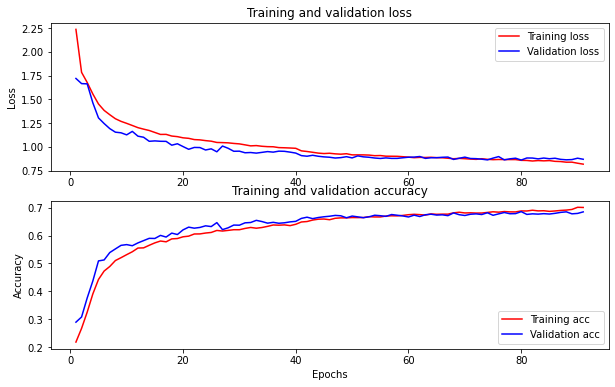

In [ ]:
with open(saved_model_directory +'/history_CNN12_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN12_OOD.jpg')

## CNN13

decrease droupout -1

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(no_class, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,), metrics=["accuracy"])


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train)

batch_size = 32 
history = model.fit(data_generator4.flow(X_train, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid, y_valid),
                    steps_per_epoch=len(X_train) / batch_size,
                    callbacks=[early_stopping, lr_scheduler],
                    use_multiprocessing=True)

Epoch 1/100
841/841 [==============================] - 19s 19ms/step - loss: 1.9922 - accuracy: 0.2521 - val_loss: 1.6289 - val_accuracy: 0.3629 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 16s 19ms/step - loss: 1.6564 - accuracy: 0.3495 - val_loss: 1.4297 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 16s 18ms/step - loss: 1.4872 - accuracy: 0.4241 - val_loss: 1.2810 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 16s 18ms/step - loss: 1.3721 - accuracy: 0.4738 - val_loss: 1.2287 - val_accuracy: 0.5398 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 16s 18ms/step - loss: 1.3005 - accuracy: 0.5074 - val_loss: 1.1789 - val_accuracy: 0.5608 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 16s 18ms/step - loss: 1.2580 - accuracy: 0.5201 - val_loss: 1.1463 - val_accuracy: 0.5568 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

117/117 [==============================] - 1s 6ms/step - loss: 0.8293 - accuracy: 0.6959


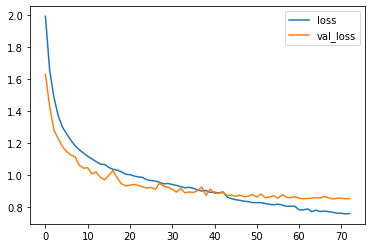

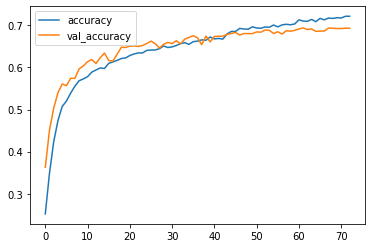

In [ ]:
model.evaluate(X_test, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'CNN13_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'CNN13_OOD_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'CNN13_OOD.h5')

with open(saved_model_directory +'/history_CNN13_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

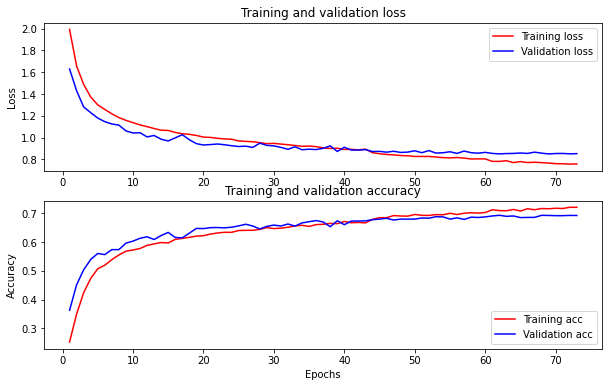

In [ ]:
with open(saved_model_directory +'/history_CNN13_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'CNN13_OOD.jpg')

#Transfer learning

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(26918, 48, 48, 1)
(26918,)
(6730, 48, 48, 1)
(6730,)
(3739, 48, 48, 1)
(3739,)


In [26]:
X_train_rgb = tf.constant(X_train)
X_train_rgb = tf.image.grayscale_to_rgb(X_train_rgb)

X_test_rgb = tf.constant(X_test)
X_test_rgb = tf.image.grayscale_to_rgb(X_test_rgb)

X_valid_rgb = tf.constant(X_valid)
X_valid_rgb = tf.image.grayscale_to_rgb(X_valid_rgb)

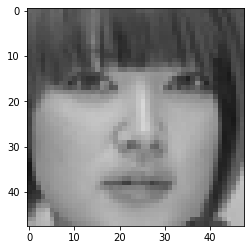

In [27]:
plt.imshow(X_train_rgb[569])

##VGG16

In [28]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [29]:
# Freeze four convolution layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [30]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train_rgb)

In [ ]:
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[48, 48, 1], padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(64, kernel_size=5, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, kernel_size=3, padding="same", activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.3),   

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="elu", kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(no_class, activation="softmax")

In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = vgg_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

batch_size = 32 
history = model.fit(data_generator4.flow(X_train_rgb, y_train, batch_size=batch_size),
                    epochs=100, validation_data=(X_valid_rgb, y_valid),
                    steps_per_epoch=len(X_train_rgb) / batch_size,
                    callbacks=[lr_reduce],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/100
841/841 [==============================] - 39s 30ms/step - loss: 2.1332 - accuracy: 0.2177 - val_loss: 1.6952 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 2/100
841/841 [==============================] - 23s 27ms/step - loss: 1.7728 - accuracy: 0.2903 - val_loss: 1.7956 - val_accuracy: 0.2652 - lr: 0.0010
Epoch 3/100
841/841 [==============================] - 23s 27ms/step - loss: 1.6475 - accuracy: 0.3572 - val_loss: 1.5404 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 4/100
841/841 [==============================] - 23s 27ms/step - loss: 1.5813 - accuracy: 0.3867 - val_loss: 1.4461 - val_accuracy: 0.4377 - lr: 0.0010
Epoch 5/100
841/841 [==============================] - 23s 27ms/step - loss: 1.5579 - accuracy: 0.3929 - val_loss: 2.0333 - val_accuracy: 0.1749 - lr: 0.0010
Epoch 6/100
841/841 [==============================] - 22s 27ms/step - loss: 1.5489 - accuracy: 0.3961 - val_loss: 1.5279 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/100
841/841 [==============================]

[1.1706739664077759, 0.5688686966896057]

117/117 [==============================] - 1s 10ms/step - loss: 1.1707 - accuracy: 0.5689


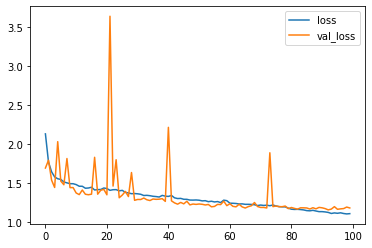

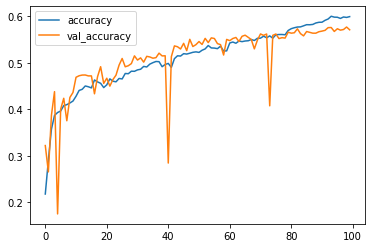

In [34]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
#plt.savefig(saved_model_directory +'VGG16_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
#plt.savefig(saved_model_directory +'VGG16_OOD_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'VGG16_OOD.h5')

with open(saved_model_directory +'/history_VGG16_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

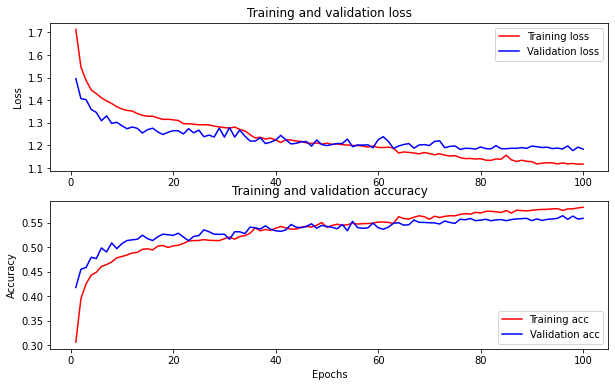

In [ ]:
with open(saved_model_directory +'/history_VGG16_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'VGG16_OOD.jpg')

## ResNet50

In [ ]:
print(X_train_rgb.shape)
print(X_valid_rgb.shape)
print(X_test_rgb.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(26918, 48, 48, 3)
(6730, 48, 48, 3)
(3739, 48, 48, 3)
(26918,)
(6730,)
(3739,)


In [ ]:
data_generator4 = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)
data_generator4.fit(X_train_rgb)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze four convolution layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = base_model(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(no_class, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                             

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
history = model.fit(data_generator4.flow(X_train_rgb, y_train),
                    epochs=25, validation_data=(X_valid_rgb, y_valid),
                    callbacks=[lrd, es],
                    use_multiprocessing=True)

model.evaluate(X_test_rgb, y_test)

Epoch 1/25
842/842 [==============================] - 32s 32ms/step - loss: 1.9927 - accuracy: 0.2158 - val_loss: 1.7807 - val_accuracy: 0.2779 - lr: 0.0010
Epoch 2/25
842/842 [==============================] - 24s 29ms/step - loss: 1.8191 - accuracy: 0.2545 - val_loss: 1.7513 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 3/25
842/842 [==============================] - 24s 29ms/step - loss: 1.7877 - accuracy: 0.2663 - val_loss: 1.7392 - val_accuracy: 0.2862 - lr: 0.0010
Epoch 4/25
842/842 [==============================] - 24s 28ms/step - loss: 1.7715 - accuracy: 0.2731 - val_loss: 1.7297 - val_accuracy: 0.2813 - lr: 0.0010
Epoch 5/25
842/842 [==============================] - 24s 29ms/step - loss: 1.7641 - accuracy: 0.2739 - val_loss: 1.7247 - val_accuracy: 0.2816 - lr: 0.0010
Epoch 6/25
842/842 [==============================] - 24s 29ms/step - loss: 1.7514 - accuracy: 0.2786 - val_loss: 1.7114 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 7/25
842/842 [==============================] - 24s 

[1.6726475954055786, 0.3081037700176239]

117/117 [==============================] - 2s 15ms/step - loss: 1.6726 - accuracy: 0.3081


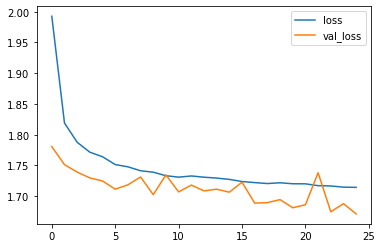

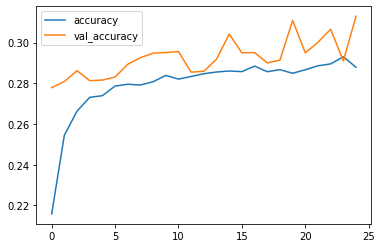

In [ ]:
model.evaluate(X_test_rgb, y_test) 
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.savefig(saved_model_directory +'Restnet_OOD_loss.jpg')
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(saved_model_directory +'Restnet_OOD_accuracy.jpg')

In [ ]:
model.save(saved_model_directory+'Restnet50_OOD.h5')

with open(saved_model_directory +'/history_Restnet50_OOD', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

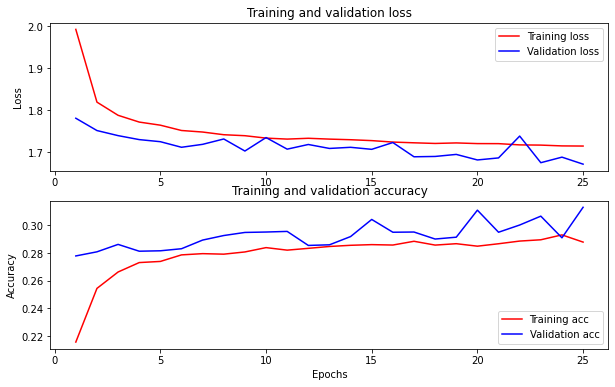

In [ ]:
with open(saved_model_directory +'/history_Restnet50_OOD', 'rb') as file:
    history=pickle.load(file)

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(saved_model_directory +'Restnet50_OOD.jpg')

# PublicTest out-of-domain 

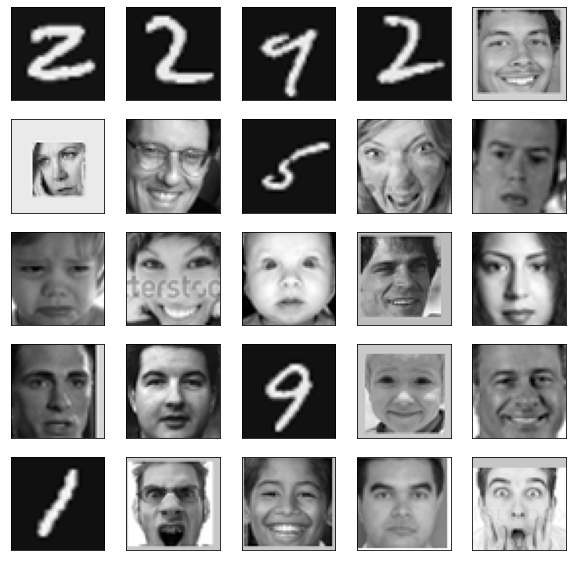

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
plt.show()

# Predict on public test set

In [ ]:
#1636
X_public = images_test_public
print(X_public.shape)

(1636, 48, 48)


In [ ]:
X_public = X_public.reshape(-1, 48, 48, 1)
print(X_public.shape)

(1636, 48, 48, 1)


In [ ]:
X_public_pred = (model.predict(X_public) > 0.5).astype("int32")
X_public_pred

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [ ]:
result = []
for i in range(len(X_public_pred)):
  r = np.argmax(X_public_pred[i])
  result.append(r)
X_public_pred_arr = np.array(result)
X_public_pred_arr

array([7, 7, 7, ..., 2, 7, 7])

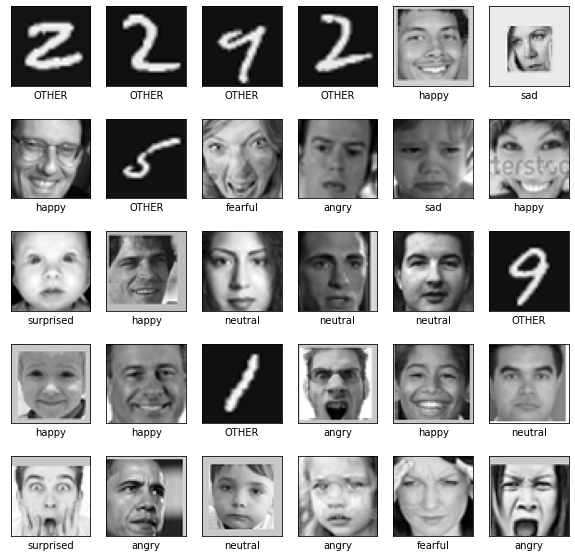

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
    plt.xlabel( EMOTIONS[ X_public_pred_arr[i] ] )
plt.show()

In [ ]:
id = []
for i in range(len(X_public_pred_arr)):
  id.append(i)

public_pred = X_public_pred_arr.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_conv_predictions_CNN13_FER2013.csv'), index=False, header=True,  encoding='utf-8')

End here